# Voice Gender Recognition

Author: Claudia Magliano

Date: 15/04/2024

In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn import tree
#from sklearn import model_selection
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.style.use('seaborn-v0_8')

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

#data = pd.read_csv('/kaggle/input/voicegender/voice.csv')
df = pd.read_csv('voice.csv')

Let's take a quick look at what the data looks like:

In [59]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


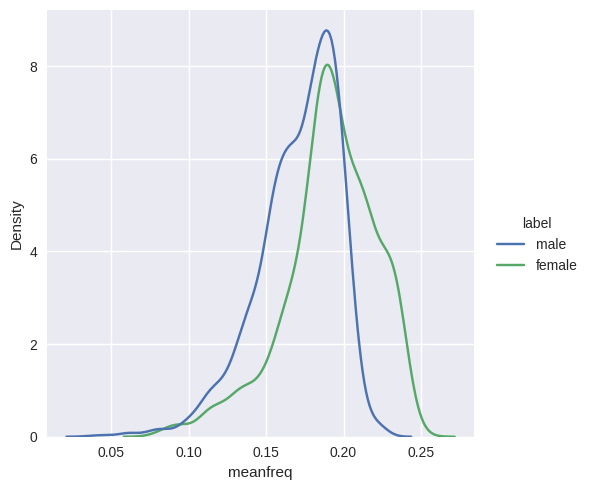

In [16]:
#plotPerColumnDistribution(data, 10, 5)
sns.displot(df,x="meanfreq",hue="label", kind="kde")

In [17]:
df.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

Transform column Label in a float column to use a heatmap plot

In [60]:
df["label"]= df["label"].str.replace("female","1")
df["label"]= df["label"].str.replace("male","0")

In [46]:
df["label"].unique()

array(['0', '1'], dtype=object)

In [61]:
df["label"] = df["label"].astype("float")

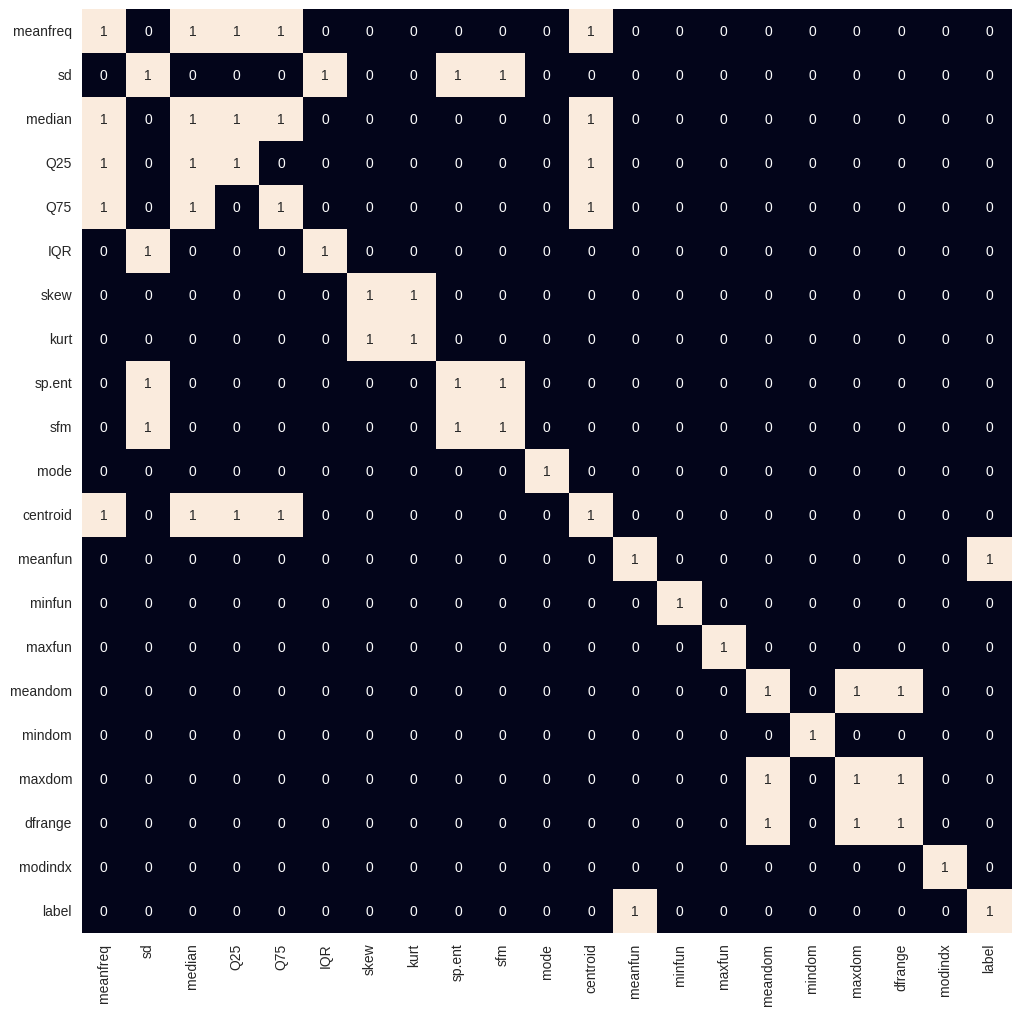

In [62]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr() > 0.7, annot=True, cbar=False)
plt.show()

From the above heat map we can conclude we have cases of highly correlated features:

‘maxdom’ and ‘drange‘ are highly correlated  

'sp.ent' and 'sfm' are highly correlated

'skew' and 'kurt' are highly correlated

so, we will remove them.

In [63]:
df = df.drop('kurt', axis=1)
df = df.drop('sp.ent', axis=1)
df = df.drop('maxdom', axis=1)

In [64]:
target = df["label"]
features = df.drop(['label'], axis=1)

After segregating features and the target variable from the dataset we will split it into 80:20 ratio for model selection.

In [65]:
xtrain, xtest, ytrain, ytest = train_test_split(
	features, target, test_size=0.2, random_state=40)

xtrain.shape, xtest.shape

((2534, 17), (634, 17))

# Normalising the data before training help us to achieve stable and fast training of the model.

In [66]:
norm = MinMaxScaler()
xtrain = norm.fit_transform(xtrain)
xtest = norm.transform(xtest)

As the data has been prepared completely let’s train some state of the art machine learning model on it.

In [67]:
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf')]

for i in range(3):
	models[i].fit(xtrain, ytrain)

	print(f'{models[i]} : ')
	print('Training Accuracy : ', metrics.roc_auc_score(ytrain, models[i].predict(xtrain)))
	print('Validation Accuracy : ', metrics.roc_auc_score(
		ytest, models[i].predict(xtest)))
	print()

LogisticRegression() : 
Training Accuracy :  0.9704858439580226
Validation Accuracy :  0.9682894015646022

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.9719268523593603

SVC() : 
Training Accuracy :  0.9806649866522963
Validation Accu

# Model Evaluation
From the above accuracies we can say that XGBClassifier classifier performing better on the validation data and training data. Let’s plot the confusion matrix as well for the validation data using the model.

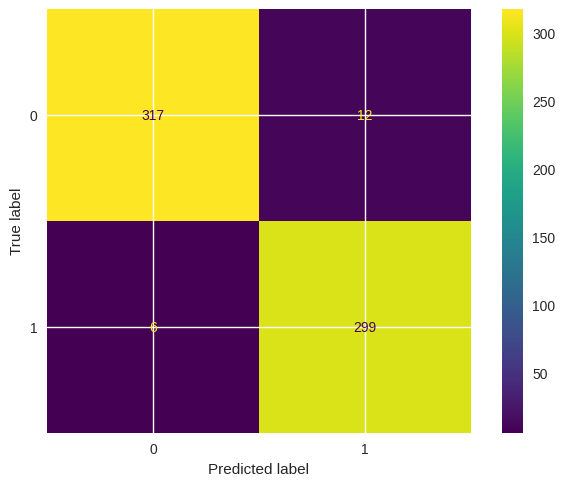

In [68]:
cm= metrics.confusion_matrix(ytest, models[1].predict(xtest))
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Let’s also print the classification report for the best performing model.

In [69]:
print(metrics.classification_report(ytest,
									models[1].predict(xtest)))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       329
         1.0       0.96      0.98      0.97       305

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634

